In [1]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
from functools import reduce

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-deep')
pd.options.display.float_format = "{:,.2f}".format

In [7]:
import pandas as pd
file_path = r'C:/Users/hujia/Downloads/量化金融/BABA.csv'
baba = pd.read_csv(file_path,)
baba['Date'] = pd.to_datetime(baba['Date'],format = '%Y-%m-%d')
baba.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-19,92.70,99.70,89.95,93.89,93.89,271879400
1,2014-09-22,92.70,92.95,89.50,89.89,89.89,66657800
2,2014-09-23,88.94,90.48,86.62,87.17,87.17,39009800
3,2014-09-24,88.47,90.57,87.22,90.57,90.57,32088000
4,2014-09-25,91.09,91.50,88.50,88.92,88.92,28598000


In [10]:
stock_price = baba[['Date','Adj Close']]
stock_price.columns = ['ds', 'y']
stock_price.head(10)

,ds,y
0,2014-09-19,93.89
1,2014-09-22,89.89
2,2014-09-23,87.17
3,2014-09-24,90.57
4,2014-09-25,88.92
5,2014-09-26,90.46
6,2014-09-29,88.75
7,2014-09-30,88.85
8,2014-10-01,86.10
9,2014-10-02,87.06


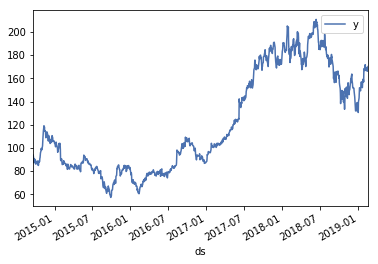

In [12]:
stock_price.plot(x = 'ds',y='y')

In [13]:
model = Prophet()
model.fit(stock_price)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [14]:
future = model.make_future_dataframe(365, freq='d')

future_boolean = future['ds'].map(lambda x : True if x.weekday() in range(0, 5) else False)
future = future[future_boolean] 

future.tail()

,ds
1469,2020-02-13
1470,2020-02-14
1473,2020-02-17
1474,2020-02-18
1475,2020-02-19


In [16]:
forecast = model.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1367,2020-02-13,93.30,56.72,126.14,58.86,125.74,-1.71,-1.71,-1.71,1.19,1.19,1.19,-2.90,-2.90,-2.90,0.00,0.00,0.00,91.59
1368,2020-02-14,93.16,54.71,123.74,58.61,125.72,-1.99,-1.99,-1.99,1.18,1.18,1.18,-3.17,-3.17,-3.17,0.00,0.00,0.00,91.17
1369,2020-02-17,92.73,53.88,124.73,57.53,125.94,-2.63,-2.63,-2.63,1.30,1.30,1.30,-3.93,-3.93,-3.93,0.00,0.00,0.00,90.10
1370,2020-02-18,92.59,54.19,122.85,57.28,125.97,-2.74,-2.74,-2.74,1.42,1.42,1.42,-4.16,-4.16,-4.16,0.00,0.00,0.00,89.85
1371,2020-02-19,92.45,53.49,123.48,57.08,126.00,-2.98,-2.98,-2.98,1.40,1.40,1.40,-4.37,-4.37,-4.37,0.00,0.00,0.00,89.47


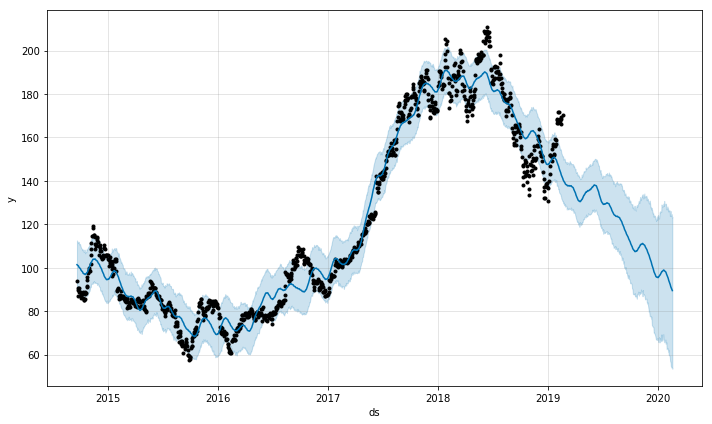

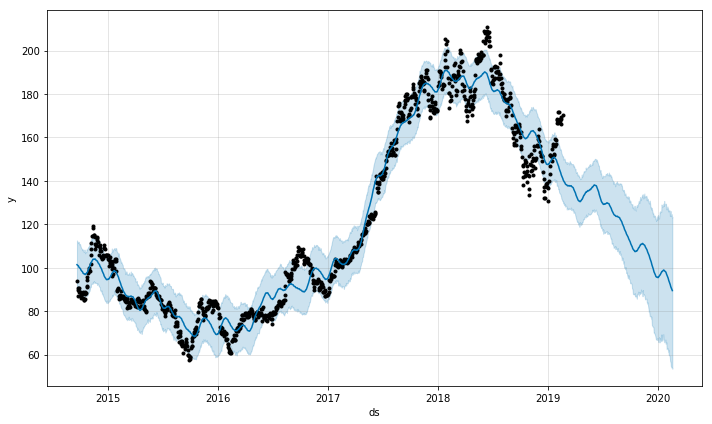

In [18]:
model.plot(forecast)

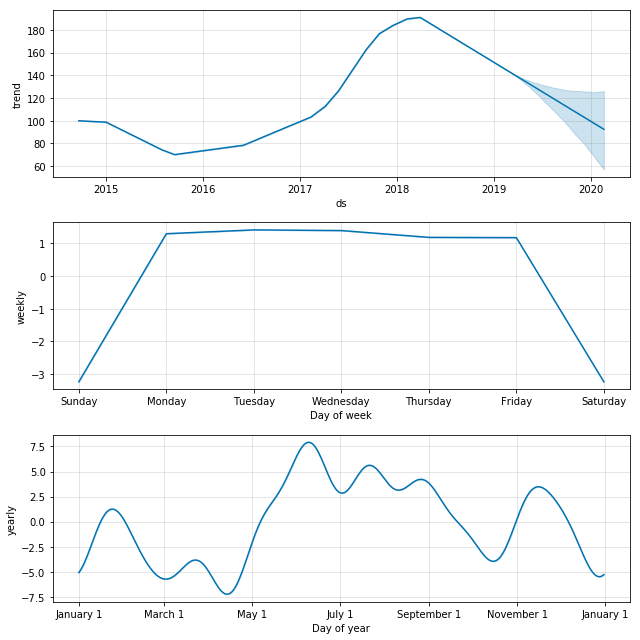

In [17]:
model.plot_components(forecast);

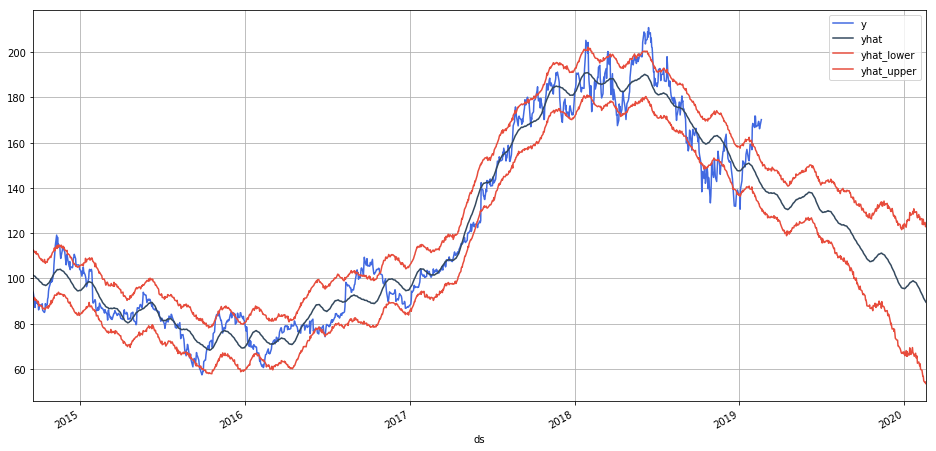

In [19]:
stock_price_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
df = pd.merge(stock_price, stock_price_forecast, on='ds', how='right')
df.set_index('ds').plot(figsize=(16,8), color=['royalblue', "#34495e", "#e74c3c", "#e74c3c"], grid=True);

In [20]:
stock_price['dayname'] = stock_price['ds'].dt.day_name()
stock_price['month'] = stock_price['ds'].dt.month
stock_price['year'] = stock_price['ds'].dt.year
stock_price['month/year'] = stock_price['month'].map(str) + '/' + stock_price['year'].map(str) 

stock_price = pd.merge(stock_price, 
stock_price['month/year'].drop_duplicates().reset_index(drop=True).reset_index(),
on='month/year',
how='left')

stock_price = stock_price.rename(columns={'index':'month/year_index'})

stock_price.tail()

,ds,y,dayname,month,year,month/year,month/year_index
1106,2019-02-12,168.71,Tuesday,2,2019,2/2019,53
1107,2019-02-13,169.40,Wednesday,2,2019,2/2019,53
1108,2019-02-14,168.38,Thursday,2,2019,2/2019,53
1109,2019-02-15,166.15,Friday,2,2019,2/2019,53
1110,2019-02-19,170.18,Tuesday,2,2019,2/2019,53


In [21]:
loop_list = stock_price['month/year'].unique().tolist()
max_num = len(loop_list) - 1
forecast_frames = []

for num, item in enumerate(loop_list):

    if num == max_num:
        pass
    else:
        df = stock_price.set_index('ds')[
        stock_price[stock_price['month/year'] == loop_list[0]]['ds'].min():\
        stock_price[stock_price['month/year'] == item]['ds'].max()]

        df = df.reset_index()[['ds', 'y']]

        model = Prophet()
        model.fit(df)

        future = stock_price[stock_price['month/year_index'] == (num + 1)][['ds']]

        forecast = model.predict(future)
        forecast_frames.append(forecast)

stock_price_forecast = reduce(lambda top, bottom: pd.concat([top, bottom], sort=False), forecast_frames)
stock_price_forecast = stock_price_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
stock_price_forecast.to_csv('stock_price_forecast.csv', index=False)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.0.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 23.0.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disa

In [22]:
stock_price_forecast.head()

,ds,yhat,yhat_lower,yhat_upper
0,2014-10-01,88.40,86.72,90.23
1,2014-10-02,88.22,86.56,90.00
2,2014-10-03,88.04,86.29,89.87
3,2014-10-06,87.49,85.69,89.40
4,2014-10-07,87.31,85.12,89.29


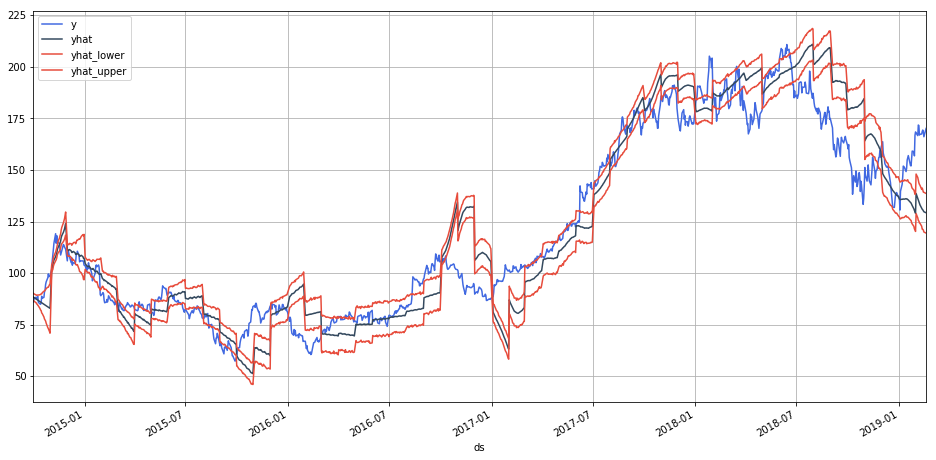

In [23]:
stock_price_forecast = pd.read_csv('stock_price_forecast.csv', parse_dates=['ds'])

df = pd.merge(stock_price[['ds','y', 'month/year_index']], stock_price_forecast, on='ds')
df['Percent Change'] = df['y'].pct_change()
df.set_index('ds')[['y', 'yhat', 'yhat_lower', 'yhat_upper']].plot(figsize=(16,8), color=['royalblue', "#34495e", "#e74c3c", "#e74c3c"], grid=True)

In [24]:
df.head()

,ds,y,month/year_index,yhat,yhat_lower,yhat_upper,Percent Change
0,2014-10-01,86.10,1,88.40,86.72,90.23,nan
1,2014-10-02,87.06,1,88.22,86.56,90.00,0.01
2,2014-10-03,88.10,1,88.04,86.29,89.87,0.01
3,2014-10-06,88.31,1,87.49,85.69,89.40,0.00
4,2014-10-07,87.67,1,87.31,85.12,89.29,-0.01


In [41]:
df['Percent Change'][3]

0.0023836549916833594

In [42]:
df['Percent Change'][0] = 0
hold = [0]*(len(df))
for i in range(1,len(df)):
    hold[i] = (reduce(lambda x,y:x+y,df['Percent Change'][:i+1]))

df['Hold'] = hold
df.head()

,ds,y,month/year_index,yhat,yhat_lower,yhat_upper,Percent Change,Hold
0,2014-10-01,86.10,1,88.40,86.72,90.23,0.00,0.00
1,2014-10-02,87.06,1,88.22,86.56,90.00,0.01,0.01
2,2014-10-03,88.10,1,88.04,86.29,89.87,0.01,0.02
3,2014-10-06,88.31,1,87.49,85.69,89.40,0.00,0.03
4,2014-10-07,87.67,1,87.31,85.12,89.29,-0.01,0.02


In [25]:
(df.dropna().set_index('ds')[['Hold', 'Prophet', 'Prophet Thresh','Seasonality']] * 1000).plot(figsize=(16,8), grid=True)

print(f"Hold = {df['Hold'].iloc[-1]*1000:,.0f}")
print(f"Prophet = {df['Prophet'].iloc[-1]*1000:,.0f}")
print(f"Prophet Thresh = {df['Prophet Thresh'].iloc[-1]*1000:,.0f}")
print(f"Seasonality = {df['Seasonality'].iloc[-1]*1000:,.0f}")

KeyError: "None of [Index(['Hold', 'Prophet', 'Prophet Thresh', 'Seasonality'], dtype='object')] are in the [columns]"

In [1]:
import datetime as dt

from prophet import Prophet
from prophet.data import YahooCloseData
from prophet.analyze import default_analyzers
from prophet.orders import Orders


class OrderGenerator(object):

    def run(self, prices, timestamp, cash, **kwargs):
        # Lets buy lots of Apple!
        symbol = "AAPL"
        orders = Orders()
        if (prices.loc[timestamp, symbol] * 100) < cash:
            orders.add_order(symbol, 100)

        return orders


prophet = Prophet()
prophet.set_universe(["AAPL", "XOM"])
prophet.register_data_generators(YahooCloseData())
prophet.set_order_generator(OrderGenerator())
prophet.register_portfolio_analyzers(default_analyzers)

backtest = prophet.run_backtest(start=dt.datetime(2010, 1, 1))
analysis = prophet.analyze_backtest(backtest)
print (analysis)
# +--------------------------------------+
# | sharpe            |    1.09754359611 |
# | average_return    | 0.00105478425027 |
# | cumulative_return |         2.168833 |
# | volatility        |  0.0152560508189 |
# +--------------------------------------+

# Generate orders for you to execute today
# Using Nov, 10 2014 as the date because there might be no data for today's
# date (Market might not be open) and we don't want examples to fail.
today = dt.datetime(2014, 11, 10)
print (prophet.generate_orders(today))
# Orders[Order(symbol='AAPL', shares=100)]

ImportError: cannot import name 'data'

In [47]:
from pandas.io import data as web

ImportError: cannot import name 'data'